In [43]:
import os
import wfdb
import pickle
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import load_model
import seaborn as sns
np.set_printoptions(suppress=True)
%matplotlib inline

## Read result dataframe

In [44]:
def drop_repeat(df,axis="RMSE",repeat=5):
    if "accuracy" in axis:
        func = max
    else:
        func = min
    num = int(len(df)/repeat)
    result_df = []
    for i in range(num):
        part_df = df[i*repeat:(i+1)*repeat]
        max_row = part_df[part_df[axis]==func(part_df[axis])]
        index = np.array(max_row["idx"])[0]
        result_df.append(max_row[max_row.idx==index])
    tmp = pd.concat(result_df,axis=0)
    return tmp

In [45]:
result_df = drop_repeat(pd.read_csv("./results/result.csv"),axis="accuracy",repeat=10)

In [46]:
result_df

,accuracy,cross_idx,idx,loss,repeat_idx
7,0.993151,0,8,0.152202,7
11,0.948052,1,12,0.162022,1
20,1.000000,2,21,0.028639,0
32,0.939189,3,33,0.294735,2
41,1.000000,4,42,0.007571,1


In [47]:
np.mean(result_df.accuracy)

0.9760783639449716

(0.8, 1.0)

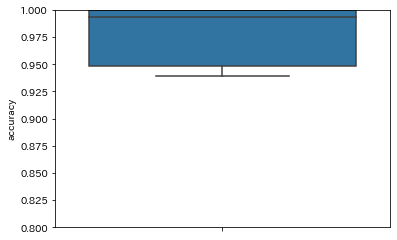

In [56]:
sns.boxplot(data=result_df,y="accuracy")
plt.ylim(0.8,1.0)

## check model accuracy

In [24]:
def load_dataset(key,save_dir="./dataset_RRI/"):
    load_path = os.path.join(save_dir,key+".pickle")
    with open(load_path,"rb") as f:
        dataset=pickle.load(f)
    return dataset["X"],dataset["y"]

In [25]:
def load_cross_dataset(cross_idx,save_dir="./dataset_RRI/"):
    load_path = os.path.join(save_dir,"dataset-cross"+str(cross_idx)+".pickle")
    with open(load_path,"rb") as f:
        dataset=pickle.load(f)
    X_train = dataset["X_train"]
    y_train = dataset["y_trian"]
    X_test = dataset["X_test"]
    y_test = dataset["y_test"]
    return X_train,y_train,X_test,y_test

In [40]:
idx = 42
cross_idx = 4
model = load_model("./results/models/"+str(idx)+"-model.h5")
X_train,y_train,X_test,y_test = load_cross_dataset(cross_idx)

In [41]:
model.evaluate(X_test,y_test)

150/150 [==============================] - 0s 3ms/step


[0.007570722152789434, 1.0]

In [42]:
model.evaluate(X_train,y_train)

1406/1406 [==============================] - 0s 121us/step


[0.25052181405583623, 0.8933143615722656]